# Importing Libraries

In [ ]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [ ]:
!curl -L -O "https://gist.githubusercontent.com/aditeyabaral/4ff1c55e600e2cf0528503b3bf02a866/raw/dd0001094cd775df6f5158e70da2aa3c05e632c0/attention.py"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5230  100  5230    0     0  23881      0 --:--:-- --:--:-- --:--:-- 23881


In [ ]:
import json
import numpy as np
import pandas as pd
import re
import string
from google.colab import files
from gensim.models import FastText
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import attention
from attention import AttentionLayer

2021-04-09 18:36:17,219 : INFO : 'pattern' package not found; tag filters are not available for English


# Reading Dataset

In [ ]:
with open ("/content/drive/MyDrive/Colab Notebooks/dataset.json") as d:
  dfd_json = json.load(d)

In [ ]:
poems = list()
haikus = list()
indices = list()

MIN_THRESHOLD_HAIKU = 5
MAX_THRESHOLD_POEM = 120

for dataset in dfd_json:
  for poem in dataset:
    for grammar_index in poem:
      if grammar_index == "poem":
        continue
      else:
        haiku_data = poem[grammar_index]
        for haiku, index in list(haiku_data.items()):
          if len(index) >= MIN_THRESHOLD_HAIKU and len(poem["poem"].split()) <= MAX_THRESHOLD_POEM:
            poems.append(poem["poem"])
            haikus.append(haiku)
            indices.append(index)

In [ ]:
len(poems), len(haikus), len(indices)

(54629, 54629, 54629)

In [ ]:
df = pd.DataFrame()
df["poem"] = poems
df["haiku"] = haikus
df["indices"] = indices

In [ ]:
print(df.shape)
df.head()

,poem,haiku,indices
0,Did the CIA tell the FBI that it knows the wor...,cia fbi the biggest weapon,"[2, 5, 9, 24, 25]"
1,Did the CIA tell the FBI that it knows the wor...,cia fbi the biggest weapon,"[2, 5, 9, 24, 25]"
2,"Dark clouds gathered overhead,\nExpelling bull...",clouds overhead bullets of the valley,"[1, 3, 5, 6, 10, 11]"
3,A vigilante lacking of heroic qualities that\n...,lacking qualities that damn criminals,"[2, 5, 6, 11, 12]"
4,"(A Diamante Poem)\nBrain\nHeavenly, hellish\nF...",diamante poem the sybaritic pathetic,"[1, 2, 10, 18, 19]"


# Preprocessing Data

In [ ]:
df["poem"][0]

'Did the CIA tell the FBI that it knows the work of the IRA?\nJust as the RCMP confused the PLO with Al-Quaieda?\nThe biggest weapon of terror is alphabetic confusion,\nIt blends together ignorance, fanaticism with dogmatic infusion.\nFor the homeless, poor and hungry, there is basic need,\nTo the yammering of the privileged and rich they do not heed.\nFood and medicine for all is delayed by poor distribution,\nIt’s waylaid by the mighty against retribution.\nIt’s hardly a wonder the world’s a more dangerous place,\nThat the rich and famous try to escape into space.\nBut the Almighty knows who deserves to be here,\nAnd it’s not the humble and poor, who have something to fear.'

In [ ]:
def cleanText(text):
  # contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
  text = text.lower()
  text = re.sub(" +", " ", text)
  text = re.sub("\n+", " ", text)
  # text = " ".join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split()])
  # return text

  # more preprocessing
  text = re.sub("[^a-zA-Z0-9\n']", " ", text)
  text = re.sub(r'\([^)]*\)', '', text)
  text = re.sub('"','', text)
  text = re.sub(r"'s\b","",text)
  text = re.sub(" +", " ", text)
  text = re.sub("\n+", " ", text)
  return text 

In [ ]:
df["poem"] = df["poem"].apply(lambda x: cleanText(x))
df["haiku"] = df["haiku"].apply(lambda x: "starttoken " + cleanText(x) + " endtoken")

In [ ]:
df["poem"][0]

'did the cia tell the fbi that it knows the work of the ira just as the rcmp confused the plo with al quaieda the biggest weapon of terror is alphabetic confusion it blends together ignorance fanaticism with dogmatic infusion for the homeless poor and hungry there is basic need to the yammering of the privileged and rich they do not heed food and medicine for all is delayed by poor distribution it s waylaid by the mighty against retribution it s hardly a wonder the world s a more dangerous place that the rich and famous try to escape into space but the almighty knows who deserves to be here and it s not the humble and poor who have something to fear '

In [ ]:
df.head()

,poem,haiku,indices
0,did the cia tell the fbi that it knows the wor...,starttoken cia fbi the biggest weapon endtoken,"[2, 5, 9, 24, 25]"
1,did the cia tell the fbi that it knows the wor...,starttoken cia fbi the biggest weapon endtoken,"[2, 5, 9, 24, 25]"
2,dark clouds gathered overhead expelling bullet...,starttoken clouds overhead bullets of the vall...,"[1, 3, 5, 6, 10, 11]"
3,a vigilante lacking of heroic qualities that b...,starttoken lacking qualities that damn crimina...,"[2, 5, 6, 11, 12]"
4,a diamante poem brain heavenly hellish floati...,starttoken diamante poem the sybaritic patheti...,"[1, 2, 10, 18, 19]"


# Training fastText

In [ ]:
X_words = list(map(word_tokenize, df["poem"].values))
y_words = list(map(word_tokenize, df["haiku"].values))

In [ ]:
ft_model = FastText(min_count=1)
ft_model.build_vocab(sentences=X_words+y_words)
ft_model.train(sentences=X_words+y_words, total_examples=ft_model.corpus_count, epochs=5)

2021-04-09 18:37:01,160 : INFO : collecting all words and their counts
2021-04-09 18:37:01,162 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-09 18:37:01,326 : INFO : PROGRESS: at sentence #10000, processed 824701 words, keeping 20587 word types
2021-04-09 18:37:01,508 : INFO : PROGRESS: at sentence #20000, processed 1722816 words, keeping 28868 word types
2021-04-09 18:37:01,700 : INFO : PROGRESS: at sentence #30000, processed 2615071 words, keeping 39605 word types
2021-04-09 18:37:01,893 : INFO : PROGRESS: at sentence #40000, processed 3564803 words, keeping 48449 word types
2021-04-09 18:37:02,104 : INFO : PROGRESS: at sentence #50000, processed 4496374 words, keeping 49699 word types
2021-04-09 18:37:02,211 : INFO : PROGRESS: at sentence #60000, processed 4974863 words, keeping 50360 word types
2021-04-09 18:37:02,240 : INFO : PROGRESS: at sentence #70000, processed 5056311 words, keeping 50709 word types
2021-04-09 18:37:02,269 : INFO : PROGRES

In [ ]:
word2embedding = {word:ft_model.wv.get_vector(word) for word in list(ft_model.wv.vocab)}

# Finding Sequence Parameters

In [ ]:
X_text = df["poem"].values
y_text = df["haiku"].values

In [ ]:
Tx = len(max(X_words, key=len))
Ty = len(max(y_words, key=len))
print(f"Tx = {Tx}\nTy = {Ty}")

Tx = 154
Ty = 15


In [ ]:
tokenizer_X = Tokenizer()
tokenizer_X.fit_on_texts(list(X_text))
X_seq = tokenizer_X.texts_to_sequences(X_text)
X_seq = pad_sequences(X_seq,  maxlen=Tx, padding='post') 
vocab_size_X = len(tokenizer_X.word_index) + 1 

tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(list(y_text))
y_seq = tokenizer_y.texts_to_sequences(y_text)
y_seq = pad_sequences(y_seq,  maxlen=Ty, padding='post') 
vocab_size_y = len(tokenizer_y.word_index) + 1 

print(f"Vocabulary Size of X = {vocab_size_X}\nVocabulary Size of y = {vocab_size_y}")

Vocabulary Size of X = 50956
Vocabulary Size of y = 22197


In [ ]:
X_seq.shape, y_seq.shape

((54629, 154), (54629, 15))

# Creating Embedding Matrices

In [ ]:
embedding_matrix_X = np.zeros((vocab_size_X, 100))
for word, i in tokenizer_X.word_index.items():
	embedding_vector = word2embedding.get(word)
	if embedding_vector is not None:
		embedding_matrix_X[i] = embedding_vector

In [ ]:
embedding_matrix_y = np.zeros((vocab_size_y, 100))
for word, i in tokenizer_y.word_index.items():
	embedding_vector = word2embedding.get(word)
	if embedding_vector is not None:
		embedding_matrix_y[i] = embedding_vector

# Creating Sequences

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.05, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51897, 154), (2732, 154), (51897, 15), (2732, 15))

# Building Model

In [ ]:
latent_dim = 1024

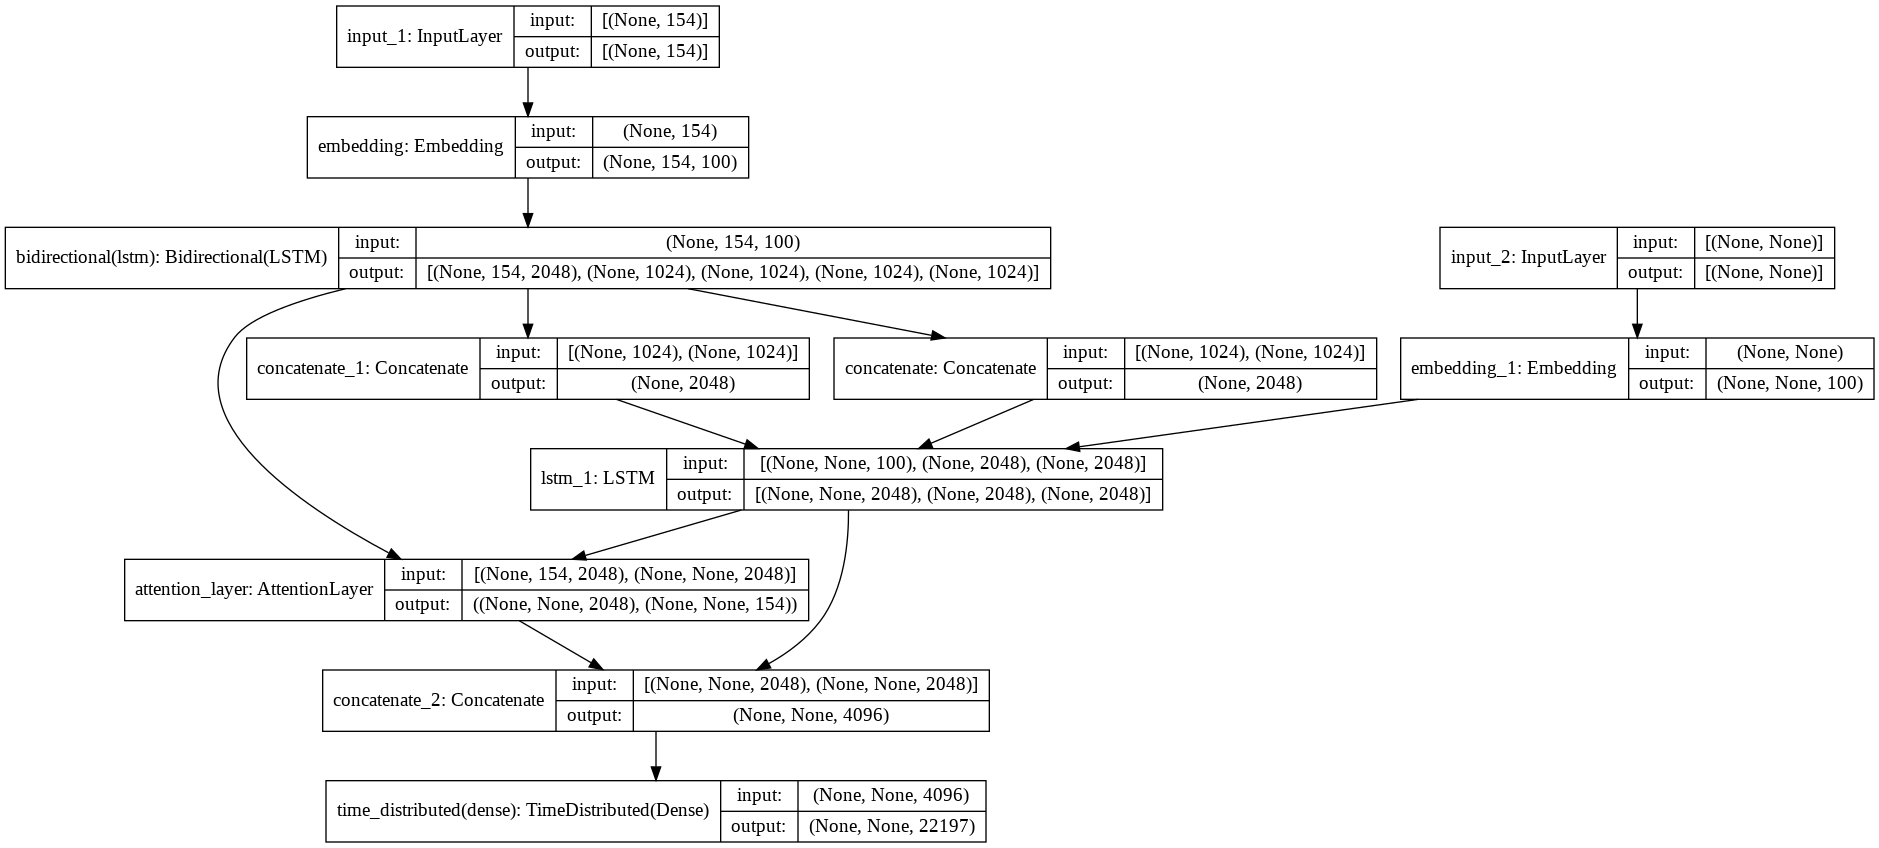

In [ ]:
#encoder
encoder_input = Input(shape=(Tx, ))
  
encoder_embedding =  Embedding(vocab_size_X, 100, weights=[embedding_matrix_X], trainable=False)(encoder_input)

encoder_LSTM_1 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_LSTM_1(encoder_embedding)

# encoder_LSTM_2 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
# encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_LSTM_2(encoder_output)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]


#decoder
decoder_input = Input(shape=(None, ))
  
decoder_embedding_layer = Embedding(vocab_size_y, 100, weights=[embedding_matrix_y], trainable=False)
decoder_embedding = decoder_embedding_layer(decoder_input)

decoder_LSTM_1 = LSTM(2*latent_dim, return_state=True, return_sequences=True)
decoder_output, decoder_fwd_state, decoder_back_state = decoder_LSTM_1(decoder_embedding, initial_state=encoder_states)


# attention
attention_layer = AttentionLayer()
attention_output, attention_states = attention_layer([encoder_output, decoder_output])
decoder_concat = Concatenate(axis=-1)([decoder_output, attention_output])

decoder_dense = TimeDistributed(Dense(vocab_size_y, activation='softmax'))
decoder_output = decoder_dense(decoder_concat)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(
    [X_train, y_train[:,:-1]], 
    y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],
    epochs=4,
    batch_size=128, 
    validation_data=([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:])
    )

Epoch 1/4
 41/406 [==>...........................] - ETA: 29:05 - loss: 4.9477 - accuracy: 0.4727

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
reverse_target_word_index = tokenizer_y.index_word
reverse_source_word_index = tokenizer_X.index_word
target_word_index = tokenizer_y.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_input, outputs=[encoder_output, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(2 * latent_dim,))
decoder_state_input_c = Input(shape=(2 * latent_dim,))
decoder_hidden_state_input = Input(shape=(Tx, 2 * latent_dim))

In [ ]:
dec_emb2 = decoder_embedding_layer(decoder_input) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_LSTM_1(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_input] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['starttoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (Ty-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starttoken']) and i!=target_word_index['endtoken']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(100):
    print("Article:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1, Tx)))
    print("\n")